# A Beginner’s Guide to Carry out Extreme Value Analysis (with Codes in Python)

## 1. Load precipitation data

Pandas has dedicated libraries for handling time series(TS) objects. Lets start by firing up the required libraries:

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context('notebook', font_scale=1.1)

#### Load the data set and look at some initial rows and data types of the columns:

In [57]:
data = pd.read_csv('data/fortprec.txt', sep='\t')
print(data.tail())
print('\n Data Types:')
print(data.dtypes)

         obs  tobs  month  day  year  Prec
36520  36520   361     12   27  1999   0.0
36521  36521   362     12   28  1999   0.0
36522  36522   363     12   29  1999   0.0
36523  36523   364     12   30  1999   0.0
36524  36524   365     12   31  1999   0.0

 Data Types:
obs        int64
tobs       int64
month      int64
day        int64
year       int64
Prec     float64
dtype: object


## 2. EVA Analysis

The Python version of L-moments is used to predict optimal parameters for a number of distributions (https://pypi.python.org/pypi/lmoments/). 

Distributions supported are listed below, with their distribution suffix:
* Exponential (EXP)
* Gamma (GAM)
* Generalised Extreme Value (GEV)
* Generalised Logistic (GLO)
* Generalised Normal (GNO)
* Generalised Pareto (GPA)
* Gumbel (GUM)
* Kappa (KAP)
* Normal (NOR)
* Pearson III (PE3)
* Wakeby (WAK)
* Weibull (WEI)
    
lmoments can be installed by one of them:
 * pip install lmoments3
 
 
As a demo, several distribution are used here.

### Import lmoments to carry out  EVA analysis

In [58]:
import lmoments3 as lm
from lmoments3 import distr

### Select annual maxima as extreme values

Text(0, 0.5, 'Precipitation [in]')

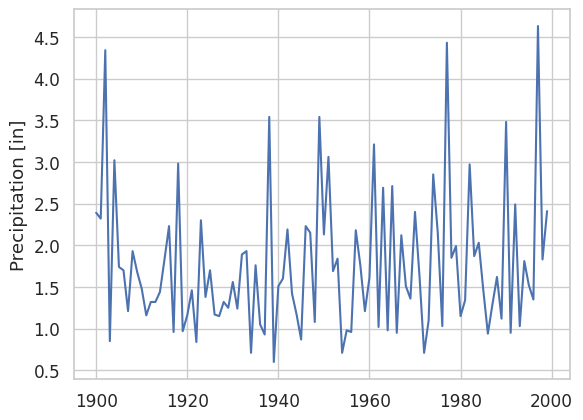

In [59]:
df = data.groupby("year").Prec.max()
plt.plot(df)
plt.ylabel('Precipitation [in]')

### Fit GEV distribution (i.e., parameter pstimation)

In [60]:
# Fit probability distribution models to the data using L-moments
expfit = distr.exp.lmom_fit(df)
gamfit = distr.gam.lmom_fit(df)
gevfit = distr.gev.lmom_fit(df)
glofit = distr.glo.lmom_fit(df)
gnofit = distr.gno.lmom_fit(df)
gpafit = distr.gpa.lmom_fit(df)
gumfit = distr.gum.lmom_fit(df)
kapfit = distr.kap.lmom_fit(df)
norfit = distr.nor.lmom_fit(df)
pe3fit = distr.pe3.lmom_fit(df)
wakfit = distr.wak.lmom_fit(df)
weifit = distr.wei.lmom_fit(df)

### Get extreme precipitation according to some return years

In [61]:
# create a range of return periods
t = np.arange(0.1, 999.1, 0.1) + 1


# Calculate quantiles for each distribution using the fitted L-moments

expST = distr.exp.ppf(1.0-1./t, **expfit)
gamST = distr.gam.ppf(1.0-1./t, **gamfit)
gevST = distr.gev.ppf(1.0-1./t, **gevfit)
gloST = distr.glo.ppf(1.0-1./t, **glofit)
gnoST = distr.gno.ppf(1.0-1./t, **gnofit)
gpaST = distr.gpa.ppf(1.0-1./t, **gpafit)
gumST = distr.gum.ppf(1.0-1./t, **gumfit)
kapST = distr.kap.ppf(1.0-1./t, **kapfit)
norST = distr.nor.ppf(1.0-1./t, **norfit)
pe3ST = distr.pe3.ppf(1.0-1./t, **pe3fit)
wakST = distr.wak.ppf(1.0-1./t, **wakfit)
weiST = distr.wei.ppf(1.0-1./t, **weifit)


# create an array of distributions and their corresponding STs
distributions = [
    ('exp', expST),
    ('gam', gamST),
    ('gev', gevST),
    ('glo', gloST),
    ('gno', gnoST),
    ('gpa', gpaST),
    ('gum', gumST),
    ('kap', kapST),
    ('nor', norST),
    ('pe3', pe3ST),
    ('wak', wakST),
    ('wei', weiST)
]

### Compare with empirical distribution

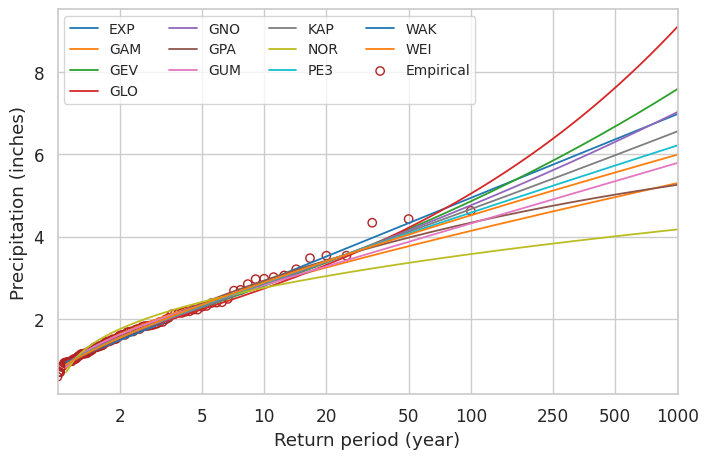

In [62]:
# create a figure and set plotting parameters
plt.figure(figsize=(8, 5))

return_periods = np.array([2, 5, 10, 20, 50, 100, 250, 500, 1000])

# set up colors for the plot
colors = sns.color_palette("tab10", len(distributions))


plt.xscale('log')
plt.xlabel('Return period (year)')
plt.ylabel('Precipitation (inches)')

# loop through distributions and plot quantiles
for i, (dist_name, dist_ST) in enumerate(distributions):
    plt.plot(t, dist_ST, c=colors[i], label=dist_name.upper(), lw=1.3)

# add a legend to the plot
plt.legend(loc='upper right')


# draw extreme values from observations(empirical distribution)
N = np.r_[1:len(df.index)+1]*1.0  # must *1.0 to convert int to float
Nmax = max(N)

plt.scatter(Nmax/N, sorted(df)[::-1], color='firebrick', marker='o',
            facecolors='none', label='Empirical',)
plt.legend(fontsize=10, ncol=4)

# Set the x-axis ticks to the desired return periods
plt.xticks(return_periods, return_periods)
plt.xlim(1, max(return_periods))


plt.savefig(f'figures/distributions.png',
            dpi=100, bbox_inches='tight',
            transparent=False, facecolor='white')

### For a more efficient method of calculating all distributions in a single loop, refer to the end of this Jupyter notebook!



## Select an Optimal Distribution 

There are several tests aviable to select the best distributons. Here we used the Kolmogorov-Smirnov(KS) test, which is available in scipy.stats.ks_2samp (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html).

This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

* Parameters:	
data1, data2 : sequence of 1-D ndarrays
two arrays of sample observations assumed to be drawn from a continuous distribution, sample sizes can be different
* Returns:	
statistic : float
KS statistic
pvalue : float
two-tailed p-value

Note:
If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [63]:
from scipy import stats as stats
# Calculate probabilities based on observations

# Create an array 'N' of float values ranging from 1 to the length of the DataFrame's index.
N = np.arange(1, len(df.index) + 1, dtype=float)

# Find the maximum value in the 'N' array,
# which is used to normalize the probabilities.
Nmax = N.max()

# Calculate probabilities 'P' by subtracting 1 from each value in 'N'
# and dividing by 'Nmax'.
P = (N - 1.0) / Nmax

# Remove the first element of 'P' (P[0]) because it's not used in the KS test.
P = np.delete(P, 0)


obs = np.sort(df.values)[1:]

In [64]:
# extreme precipitations
expSTo = distr.exp.ppf(P, **expfit)
gamSTo = distr.gam.ppf(P, **gamfit)
gevSTo = distr.gev.ppf(P, **gevfit)
gloSTo = distr.glo.ppf(P, **glofit)
gnoSTo = distr.gno.ppf(P, **gnofit)
gpaSTo = distr.gpa.ppf(P, **gpafit)
gumSTo = distr.gum.ppf(P, **gumfit)
kapSTo = distr.kap.ppf(P, **kapfit)
norSTo = distr.nor.ppf(P, **norfit)
pe3STo = distr.pe3.ppf(P, **pe3fit)
wakSTo = distr.wak.ppf(P, **wakfit)
weiSTo = distr.wei.ppf(P, **weifit)


# do ks test
ks = [('exp',  stats.ks_2samp(obs, expSTo)),
      ('gam', stats.ks_2samp(obs, gamSTo)),
      ('gev', stats.ks_2samp(obs, gevSTo)),
      ('glo', stats.ks_2samp(obs, gloSTo)),
      ('gno', stats.ks_2samp(obs, gnoSTo)),
      ('gpa', stats.ks_2samp(obs, gpaSTo)),
      ('gum', stats.ks_2samp(obs, gumSTo)),
      ('kap', stats.ks_2samp(obs, kapSTo)),
      ('nor', stats.ks_2samp(obs, norSTo)),
      ('pe3', stats.ks_2samp(obs, pe3STo)),
      ('wak', stats.ks_2samp(obs, wakSTo)),
      ('wei', stats.ks_2samp(obs, weiSTo))]

labels = ['Distribution', 'KS (statistics, pvalue)']
ks = pd.DataFrame(ks, columns=labels)
ks

,Distribution,"KS (statistics, pvalue)"
0,exp,"(0.0707070707070707, 0.9669304174079811)"
1,gam,"(0.0707070707070707, 0.9669304174079811)"
2,gev,"(0.04040404040404041, 0.9999986267507212)"
3,glo,"(0.050505050505050504, 0.9996581360296253)"
4,gno,"(0.04040404040404041, 0.9999986267507212)"
5,gpa,"(0.050505050505050504, 0.9996581360296253)"
6,gum,"(0.06060606060606061, 0.9938526535086548)"
7,kap,"(0.050505050505050504, 0.9996581360296253)"
8,nor,"(0.1111111111111111, 0.5765169937891337)"
9,pe3,"(0.050505050505050504, 0.9996581360296253)"


#### It can be found that theses distributions have very similary performance. However, GEV gets the champion with minimum statistics and maximum pvalue. So redraw the plot based on the selected GEV distribution.

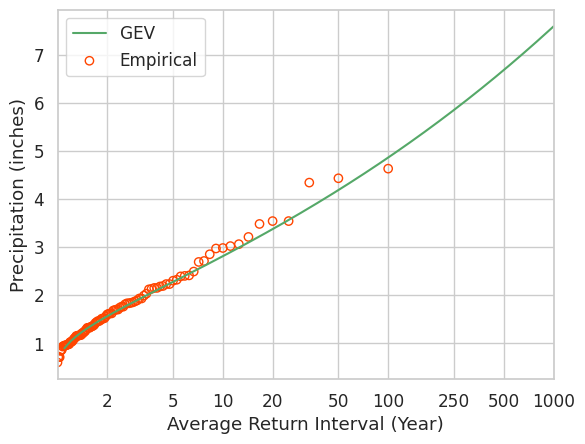

In [65]:
plt.xscale('log')
plt.xlabel('Average Return Interval (Year)')
plt.ylabel('Precipitation (inches)')
line1, = plt.plot(t, gevST, 'g', label='GEV')

# draw extreme values from observations(empirical distribution)
N    = np.r_[1:len(df.index)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)

plt.scatter(Nmax/N, sorted(df)[::-1], color = 'orangered',
            facecolors='none', label='Empirical')
plt.legend()

# Set the x-axis ticks to the desired return periods
plt.xticks(return_periods, return_periods)
plt.xlim(1, max(return_periods));

## Other permormance metrics


The **Akaike Information Criterion (AIC)** and the **Bayesian Information Criterion (BIC)** are statistical metrics used for model selection and comparison. Here's a summary of their key points:

### Akaike Information Criterion (AIC):
 * Developed by Hirotugu Akaike.
* AIC balances model fit and model complexity.
* AIC formula: $AIC = -2 * log-likelihood + 2 * k$.
* The log-likelihood quantifies the goodness of fit.
* "k" represents the number of model parameters or degrees of freedom.
* Lower AIC values indicate better models.
* AIC rewards models that fit well but penalizes for complexity.
* Used for relative model comparison and selection.
* Often preferred when sample size is small, as it is less stringent on model complexity.

  

### Bayesian Information Criterion (BIC): 

* Developed by Gideon Schwarz, derived from Bayesian probability theory.
* BIC also balances model fit and model complexity.
* BIC formula: $BIC = -2 * log-likelihood + k * log(n)$.
* "k" is the number of model parameters, and "n" is the sample size.
* Stronger penalty for complexity compared to AIC.
* Favors simpler models, especially with larger sample sizes.
* Used for relative model comparison and selection.
* Helpful when a stronger penalty for complexity is desired.

  

In summary, both *AIC* and *BIC* are used to compare models and select the best-fitting model from a set of candidates. *AIC* is more lenient on model complexity, making it suitable when sample sizes are small, while BIC places a stronger penalty on complex models and is favored when simplicity is a priority, particularly with larger sample sizes. The choice between AIC and BIC depends on the specific context and modeling goals.

In [66]:

from lmoments3 import stats as lm_stats

distribution_paras = {'exp': expfit,
                      'gam': gamfit,
                      'gev': gevfit,
                      'glo': glofit,
                      'gno': gnofit,
                      'gpa': gpafit,
                      'gum': gumfit,
                      'kap': kapfit,
                      'nor': norfit,
                      'pe3': pe3fit,
                      'wak': wakfit,
                      'wei': weifit}


performance = []

for dist_name, dist_paras in distribution_paras.items():
    # Akaike Information Criterion (AIC)
    aic_i = lm_stats.AIC(df, dist_name, dist_paras)

    # Bayesian Information Criterion
    bic_i = lm_stats.BIC(df, dist_name, dist_paras)
    performance.append((dist_name, aic_i, bic_i))

labels = ['Distribution', 'AIC', 'BIC']
performance = pd.DataFrame(performance, columns=labels)
performance

,Distribution,AIC,BIC
0,exp,inf,inf
1,gam,223.423277,231.238787
2,gev,216.382372,224.197882
3,glo,219.920932,227.736443
4,gno,214.920638,222.736149
5,gpa,inf,inf
6,gum,219.846571,225.056911
7,kap,216.948500,227.369181
8,nor,250.542687,255.753027
9,pe3,inf,inf


## End Notes

Through this guide I have tried to give you a basic idea how to carry out extreme value analysis (EVA) upon a time series data of interest.

In fact, the analysis will become more complicated in a real practice as high quality data are not always available. Sometimes, you have to spend a lot of time cleaning the data. For example, fill the missing values and check outliers.

In addition, carrying out EVA always fits several distributions, simultaneouly. Then a goodness-of-fit measure (e.g., Anderson-Darling test) is used to select the optimal one.

This is just a start. You can try more.


In [67]:
from scipy.stats import anderson

dist = ['norm', 'expon', 'gumbel', 'extreme1', 'logistic']

a_results = []

for dist_i in dist:
    result = anderson(df, dist=dist_i)
    a_results.append((dist_i, result.statistic))
    
    # Extract test statistic and critical values
    significance_level = result.significance_level
    test_statistic = result.statistic
    critical_values = result.critical_values
    
    print('-'*60)

    # Display the results
    print("Anderson-Darling test statistic:", test_statistic)
    print("Critical values at different significance levels:")
    for i, alpha in enumerate(significance_level):
        print(f"\tSignificance level {alpha}%: {critical_values[i]}")
    
labels = ['Distribution', 'statistic']
a_results = pd.DataFrame(a_results, columns=labels)
a_results

------------------------------------------------------------
Anderson-Darling test statistic: 2.899671421626863
Critical values at different significance levels:
	Significance level 15.0%: 0.555
	Significance level 10.0%: 0.632
	Significance level 5.0%: 0.759
	Significance level 2.5%: 0.885
	Significance level 1.0%: 1.053
------------------------------------------------------------
Anderson-Darling test statistic: 15.284537232476879
Critical values at different significance levels:
	Significance level 15.0%: 0.917
	Significance level 10.0%: 1.072
	Significance level 5.0%: 1.333
	Significance level 2.5%: 1.596
	Significance level 1.0%: 1.945
------------------------------------------------------------
Anderson-Darling test statistic: 7.077352274279647
Critical values at different significance levels:
	Significance level 25.0%: 0.465
	Significance level 10.0%: 0.625
	Significance level 5.0%: 0.742
	Significance level 2.5%: 0.86
	Significance level 1.0%: 1.018
----------------------------

/home/jdmantillaq/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Distribution,statistic
0,norm,2.899671
1,expon,15.284537
2,gumbel,7.077352
3,extreme1,7.077352
4,logistic,1.809842


## Efficient method of calculating all distributions in a single loop!


This loop iterates through a list of distribution names (distribution_names) and performs the following steps for each distribution:  

1. **Fit L-moments**: The loop uses the lmom_fit method of the corresponding distribution class (e.g., distr.exp.lmom_fit for the exponential distribution) to fit L-moments to the data (df). L-moments are a set of statistical moments that are robust to outliers and missing values.
2. **Calculate quantiles**: Using the fitted L-moments, the loop calculates the quantiles of the distribution for the given return periods (t). Quantiles divide a population into groups based on a given probability. In this case, we are calculating the quantiles for 1000 return periods.
3. **Store fit and quantiles**: The loop stores the fitted L-moments and calculated quantiles in a dictionary (distribution_fit). The dictionary key is the distribution name, and the value is a tuple containing the fitted L-moments and quantiles.

This loop effectively fits multiple distributions to the data and calculates their quantiles for different return periods. The resulting dictionary (`distribution_fit`) contains all the necessary information for further analysis and comparison of the different distributions.

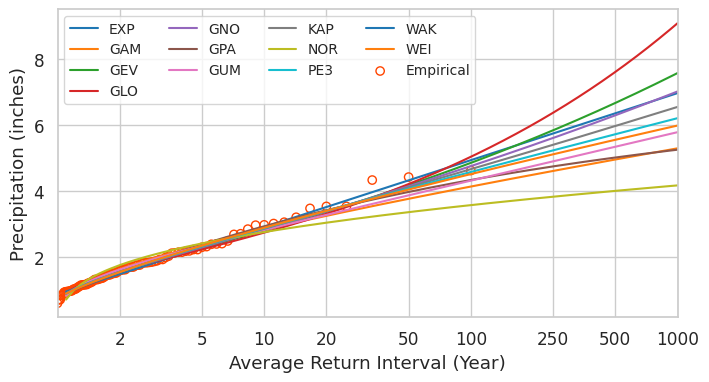

In [68]:
# List of distribution names and their corresponding comments
distribution_names = [
    'exp',   # Exponential Distribution
    'gam',   # Gamma Distribution
    'gev',   # Generalized Extreme Value Distribution
    'glo',   # Generalized Logistic Distribution
    'gno',   # Generalized Normal Distribution
    'gpa',   # Generalized Pareto Distribution
    'gum',   # Gumbel Distribution
    'kap',   # Kappa Distribution
    'nor',   # Normal Distribution
    'pe3',   # Pearson Type III Distribution
    'wak',   # Wakeby Distribution
    'wei'    # Weibull Distribution
]

# Create a range of return periods
t = np.arange(0.1, 999.1, 0.1) + 1

# Dictionary to store distribution fits and quantiles
distribution_fit = {}

# Loop through distribution names
for dist_name in distribution_names:
    # Fit L-moments for the distribution to the data
    dist_fit = distr.__dict__[dist_name].lmom_fit(df)
    
    # Calculate quantiles for the distribution using the fitted L-moments
    dist_quantiles = distr.__dict__[dist_name].ppf(1.0 - 1.0 / t, **dist_fit)
    
    # Store the fit and quantiles in the dictionary
    distribution_fit[dist_name] = (dist_fit, dist_quantiles)

# Create a figure for the plot
plt.figure(figsize=(8, 4))

# Set up colors for the plot
colors = sns.color_palette("tab10", len(distribution_names))

# Set plotting parameters
plt.xscale('log')
plt.xlabel('Average Return Interval (Year)')
plt.ylabel('Precipitation (inches)')

# Loop through distributions and plot quantiles
for i, (key, (dist_fit, dist_quantiles)) in enumerate(distribution_fit.items()):
    plt.plot(t, dist_quantiles, c=colors[i], label=key.upper())

# Add a legend to the plot
plt.legend(loc='upper right')

# Draw extreme values from observations (empirical distribution)
N = np.r_[1:len(df.index)+1]*1.0  # Must multiply by 1.0 to convert int to float
Nmax = max(N)

plt.scatter(Nmax/N, sorted(df)[::-1], color='orangered',
            facecolors='none', label='Empirical')

# Add a legend to the plot
plt.legend(fontsize=10, ncol=4)

# Set the x-axis ticks to the desired return periods
plt.xticks(return_periods, return_periods)
plt.xlim(1, max(return_periods));
